FETCHREACH — REINFORCE

CELL 0- Module Install and Verify

In [3]:
# !pip install gymnasium gymnasium-robotics numpy matplotlib torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


ERROR: Could not find a version that satisfies the requirement gymnasium (from versions: none)
ERROR: No matching distribution found for gymnasium


In [15]:
import gymnasium as gym
import gymnasium_robotics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt
import time

print("All modules installed correctly")
print("CUDA available:", torch.cuda.is_available())


All modules installed correctly
CUDA available: True


In [16]:
import sys
print(sys.version)


3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]


🔵 CELL 1 — Imports & Setup

In [17]:
# import gymnasium as gym
# import gymnasium_robotics
# import numpy as np
# import matplotlib.pyplot as plt
# import time

# from stable_baselines3 import A2C
# from stable_baselines3.common.monitor import Monitor
# from stable_baselines3.common.env_util import make_vec_env


🔵 CELL 2 — Environment Creation (Monitored)

We wrap the environment with Monitor to log rewards, episode lengths, etc.

In [18]:
def make_env():
    env = gym.make("FetchReach-v4")
    return env

env = make_env()


🔵 CELL 3 — Policy Network (REINFORCE)

In [19]:
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, act_dim),
        )
        # Reduced initial exploration noise
        self.log_std = nn.Parameter(torch.ones(act_dim) * -1.0)

    def forward(self, x):
        mean = self.net(x)
        std = self.log_std.exp()
        return Normal(mean, std)


🔵 CELL 4 — Initialization (SAME ROLE AS MODEL INIT)

In [ ]:
obs_dim = env.observation_space["observation"].shape[0]
act_dim = env.action_space.shape[0]

policy = PolicyNet(obs_dim, act_dim)

optimizer = optim.Adam(
    policy.parameters(),
    lr=1e-4
)

gamma = 0.95
TOTAL_EPISODES = 2000


🔵 CELL 5 — Training (REINFORCE LOOP)

In [21]:
episode_returns = []

baseline_value = 0.0
baseline_alpha = 0.9

for ep in range(TOTAL_EPISODES):
    obs, info = env.reset()
    log_probs = []
    rewards = []

    done = False
    while not done:
        obs_tensor = torch.tensor(obs["observation"], dtype=torch.float32)
        dist = policy(obs_tensor)
        action = dist.sample()
        log_probs.append(dist.log_prob(action).sum())

        obs, reward, terminated, truncated, info = env.step(action.detach().numpy())
        rewards.append(reward)
        done = terminated or truncated

    # Compute discounted returns
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)

    returns = torch.tensor(returns, dtype=torch.float32)

    # Normalize returns
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    # ---- REINFORCE + BASELINE ----
    baseline_value = baseline_alpha * baseline_value + (1 - baseline_alpha) * returns.mean().item()
    advantages = returns - baseline_value

    loss = -torch.sum(torch.stack(log_probs) * advantages)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ep_return = sum(rewards)
    episode_returns.append(ep_return)

    if ep % 25 == 0:
        print(f"Episode {ep} | Return: {ep_return:.2f}")


Episode 0 | Return: -50.00
Episode 25 | Return: -42.00
Episode 50 | Return: -50.00
Episode 75 | Return: -44.00
Episode 100 | Return: -50.00
Episode 125 | Return: -50.00
Episode 150 | Return: -50.00
Episode 175 | Return: -50.00
Episode 200 | Return: -50.00
Episode 225 | Return: -50.00
Episode 250 | Return: -50.00
Episode 275 | Return: -49.00
Episode 300 | Return: -50.00
Episode 325 | Return: -50.00
Episode 350 | Return: -50.00
Episode 375 | Return: -50.00
Episode 400 | Return: -50.00
Episode 425 | Return: -50.00
Episode 450 | Return: -46.00
Episode 475 | Return: -50.00
Episode 500 | Return: -50.00
Episode 525 | Return: -47.00
Episode 550 | Return: -50.00
Episode 575 | Return: -50.00
Episode 600 | Return: -50.00
Episode 625 | Return: -50.00
Episode 650 | Return: -50.00
Episode 675 | Return: -50.00
Episode 700 | Return: -50.00
Episode 725 | Return: -50.00
Episode 750 | Return: -50.00
Episode 775 | Return: -50.00
Episode 800 | Return: -50.00
Episode 825 | Return: -50.00
Episode 850 | Retur

🔵 CELL 6 — Save Model (SAME ROLE)

In [22]:
torch.save(policy.state_dict(), "reinforce_fetchreach.pt")


🔵 CELL7 — Human Evaluation (MATCHES SAC FLOW)

In [23]:
eval_env = gym.make("FetchReach-v4", render_mode="human")
policy.load_state_dict(torch.load("reinforce_fetchreach.pt"))

obs, info = eval_env.reset()

distances = []
rewards = []

for step in range(600):
    obs_tensor = torch.tensor(obs["observation"], dtype=torch.float32)
    dist_policy = policy(obs_tensor)
    action = dist_policy.mean

    obs, reward, terminated, truncated, info = eval_env.step(action.detach().numpy())

    achieved = obs["achieved_goal"]
    desired = obs["desired_goal"]
    dist = np.linalg.norm(achieved - desired)

    distances.append(dist)
    rewards.append(reward)

    print(f"{step:03d} | distance={dist:.4f} | reward={reward}")

    time.sleep(0.01)

    if terminated or truncated:
        obs, info = eval_env.reset()

eval_env.close()


C:\Users\kanan\AppData\Local\Temp\ipykernel_24240\2205921985.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("reinforce_fetchreach.pt")

000 | distance=0.0886 | reward=-1.0
001 | distance=0.0703 | reward=-1.0
002 | distance=0.0703 | reward=-1.0
003 | distance=0.0879 | reward=-1.0
004 | distance=0.1146 | reward=-1.0
005 | distance=0.1445 | reward=-1.0
006 | distance=0.1750 | reward=-1.0
007 | distance=0.2056 | reward=-1.0
008 | distance=0.2356 | reward=-1.0
009 | distance=0.2646 | reward=-1.0
010 | distance=0.2923 | reward=-1.0
011 | distance=0.3187 | reward=-1.0
012 | distance=0.3437 | reward=-1.0
013 | distance=0.3670 | reward=-1.0
014 | distance=0.3887 | reward=-1.0
015 | distance=0.4086 | reward=-1.0
016 | distance=0.4267 | reward=-1.0
017 | distance=0.4430 | reward=-1.0
018 | distance=0.4575 | reward=-1.0
019 | distance=0.4703 | reward=-1.0
020 | distance=0.4815 | reward=-1.0
021 | distance=0.4915 | reward=-1.0
022 | distance=0.5003 | reward=-1.0
023 | distance=0.5082 | reward=-1.0
024 | distance=0.5153 | reward=-1.0
025 | distance=0.5219 | reward=-1.0
026 | distance=0.5279 | reward=-1.0
027 | distance=0.5336 | rewa

🔵 CELL 8 — Plot Distance-to-Goal Over Time (IMPORTANT)

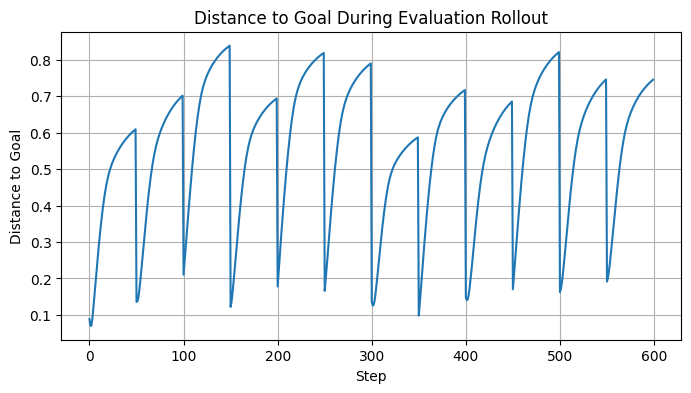

In [24]:
plt.figure(figsize=(8,4))
plt.plot(distances)
plt.xlabel("Step")
plt.ylabel("Distance to Goal")
plt.title("Distance to Goal During Evaluation Rollout")
plt.grid(True)
plt.show()


🔵 CELL 9 — Formal Evaluation (100 Episodes)

This is where comparison metrics come from.

In [25]:
eval_env = gym.make("FetchReach-v4")

episode_rewards = []
episode_success = []
episode_lengths = []
final_distances = []
action_magnitudes = []

N_EVAL_EPISODES = 100

for ep in range(N_EVAL_EPISODES):
    obs, info = eval_env.reset()
    done = False
    total_reward = 0
    steps = 0
    actions = []

    while not done:
        obs_tensor = torch.tensor(obs["observation"], dtype=torch.float32)
        dist_policy = policy(obs_tensor)
        action = dist_policy.mean

        obs, reward, terminated, truncated, info = eval_env.step(action.detach().numpy())

        total_reward += reward
        steps += 1
        actions.append(np.linalg.norm(action.detach().numpy()))

        done = terminated or truncated

    episode_rewards.append(total_reward)
    episode_success.append(info.get("is_success", 0))
    episode_lengths.append(steps)
    final_distances.append(
        np.linalg.norm(obs["achieved_goal"] - obs["desired_goal"])
    )
    action_magnitudes.append(np.mean(actions))


🔵 CELL 10 — Core Numerical Metrics (REPORT THESE)

In [26]:
print("Average Episodic Reward:", np.mean(episode_rewards))
print("Reward Std Dev:", np.std(episode_rewards))

print(f"Success Rate: {np.mean(episode_success)*100:.2f}%")

print("Average Episode Length:", np.mean(episode_lengths))

print("Mean Final Distance:", np.mean(final_distances))
print("Final Distance Std:", np.std(final_distances))

print("Mean Action Magnitude:", np.mean(action_magnitudes))


Average Episodic Reward: -49.96
Reward Std Dev: 0.24166092
Success Rate: 0.00%
Average Episode Length: 50.0
Mean Final Distance: 0.7117568664203638
Final Distance Std: 0.08851714819194804
Mean Action Magnitude: 1.7541487


🔵 CELL 11 — Success Rate Over Episodes

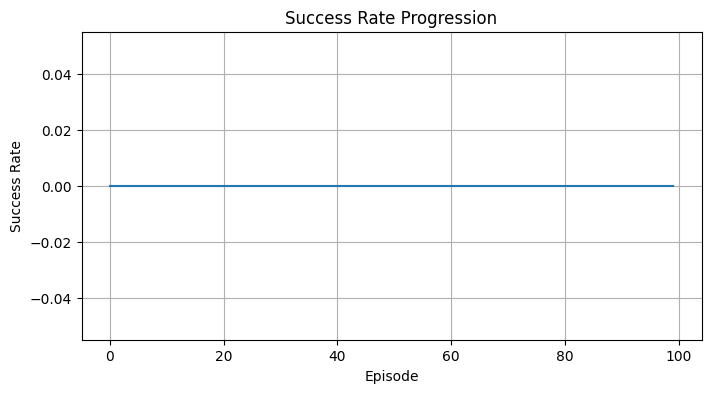

In [27]:
success_curve = np.cumsum(episode_success) / np.arange(1, len(episode_success)+1)

plt.figure(figsize=(8,4))
plt.plot(success_curve)
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.title("Success Rate Progression")
plt.grid(True)
plt.show()


🔵 CELL 12 — Reward Distribution (Stability)

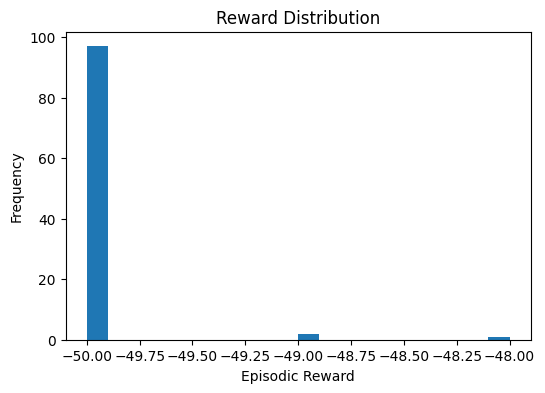

In [28]:
plt.figure(figsize=(6,4))
plt.hist(episode_rewards, bins=20)
plt.xlabel("Episodic Reward")
plt.ylabel("Frequency")
plt.title("Reward Distribution")
plt.show()


🔵 CELL 13 — Convergence Time (Impressive Metric)

In [29]:
window = 20
rolling_success = np.convolve(
    episode_success,
    np.ones(window)/window,
    mode="valid"
)

threshold = 0.8
conv_episode = np.argmax(rolling_success >= threshold)

print("Convergence Episode (80% success):", conv_episode)


Convergence Episode (80% success): 0
